In [250]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [251]:
#bolTrainagain = False # will try to load data if false 

In [252]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [253]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekdays  = get_days_of_protos("Weekday", df_training)
training_fridays  = get_days_of_protos("Friday", df_training)
training_weekends  = get_days_of_protos("Weekend", df_training)

training_weekends = training_weekends[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays)
f_length = len(training_fridays)
we_length = len(training_weekends)




In [254]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  

In [255]:
from sklearn.linear_model import LinearRegression

In [256]:
def calcRunningPredcitionErrorNowReg(t_days,training_days,max_value,starting_hour=7,window_lenth=2,ending_hour=23):
    #starting_hour=7
    #window_lenth=2
    #ending_hour=23
    training_matrix=np.zeros((len(training_days), 48))
    i=0
    for day_list in training_days:
        temp=day_list.tolist()
        training_matrix[i,:]=temp
        i=i+1
    training_diff_matrix=np.diff(training_matrix,axis=1,prepend=0)
    
    testing_matrix=np.zeros((len(t_days), 48))
    i=0
    for day_list in t_days:
        temp=day_list.tolist()
        testing_matrix[i,:]=temp
        i=i+1
    testing_diff_matrix=np.diff(testing_matrix,axis=1,prepend=0)
    
    limit_indx_vec = np.arange (starting_hour*2, ending_hour*2, 1)
    reg_running_error_vec=np.zeros((len(limit_indx_vec),len(t_days)))
    cont=0
    for limit_indx in limit_indx_vec: 
        X_trainT=training_diff_matrix[:,0:limit_indx]
        y_trainT=training_matrix[:,(limit_indx+window_lenth)]
        model = LinearRegression().fit(X_trainT, y_trainT)

        X_testT=testing_diff_matrix[:,0:limit_indx]
        y_testT=testing_matrix[:,(limit_indx+window_lenth)]
        y_pred = model.predict(X_testT)
        reg_running_error_vec[cont,:] = abs(y_pred-y_testT)/max_value
        cont=cont+1
    return reg_running_error_vec

In [257]:
starting_hour=7
window_lenth=2
ending_hour=23
limit_indx_vec = np.arange (starting_hour*2, ending_hour*2, 1)

In [258]:
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_mondays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=reg_running_error_vec
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_tuesdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_wednesdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_thursdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
                                                      
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)

In [259]:
reg_running_error_fr=calcRunningPredcitionErrorNowReg(testing_fridays,training_fridays,max_value,
                                                       starting_hour,window_lenth,ending_hour)

In [260]:
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_saturdays,training_weekends,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_we=reg_running_error_vec
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_sundays,training_weekends,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_we=np.concatenate((reg_running_error_we, reg_running_error_vec), axis=1)

In [261]:
try:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()
except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
    print('no saved data: recalcualting')
    bolTrainagain = Tru

In [262]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00348



In [263]:
optimal_params_weekdaytn

 final_simplex: (array([[0.29, 0.03, 0.79, 0.09],
       [0.29, 0.03, 0.79, 0.09],
       [0.29, 0.03, 0.79, 0.09],
       [0.29, 0.03, 0.79, 0.09],
       [0.29, 0.03, 0.79, 0.09]]), array([0.02, 0.02, 0.02, 0.02, 0.02]))
           fun: 0.015708785409765964
       message: 'Optimization terminated successfully.'
          nfev: 256
           nit: 152
        status: 0
       success: True
             x: array([0.29, 0.03, 0.79, 0.09])

In [264]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.29, 0.03, 0.79, 0.09])

In [265]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


### FRIDAYS

In [266]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00749

stdv per time-step


In [267]:
optimal_params_fridaytn

 final_simplex: (array([[0.31, 0.04, 0.77, 0.19],
       [0.31, 0.04, 0.77, 0.19],
       [0.31, 0.04, 0.77, 0.19],
       [0.31, 0.04, 0.77, 0.19],
       [0.31, 0.04, 0.77, 0.19]]), array([0.02, 0.02, 0.02, 0.02, 0.02]))
           fun: 0.016167878924170764
       message: 'Optimization terminated successfully.'
          nfev: 247
           nit: 143
        status: 0
       success: True
             x: array([0.31, 0.04, 0.77, 0.19])

In [268]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [269]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

## save the model fits

In [270]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.00670



In [271]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.36, 0.12, 0.94, 0.09])

In [272]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



In [273]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Mollet -----------
Mean Arrival Time   = 07:01h
stdv Arrival        =  0:49h
Mean Departure Time = 18:59h
stdv Departure      =  2:15h
--------- FRIDAYS Mollet -----------
Mean Arrival Time   = 07:21h
stdv Arrival        =  1:00h
Mean Departure Time = 18:28h
stdv Departure      =  4:38h
--------- WEEKENDS Mollet -----------
Mean Arrival Time   = 08:33h
stdv Arrival        =  2:46h
Mean Departure Time = 22:39h
stdv Departure      =  2:13h


In [274]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [275]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [276]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [277]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

## Running  Prediction

In [278]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)


starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                                             tn_proto,max_value,starting_hour,pred_window)
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
            
            
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [279]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

[2.75 2.65 4.63 7.14 3.24 5.53 1.52 1.37 2.34]


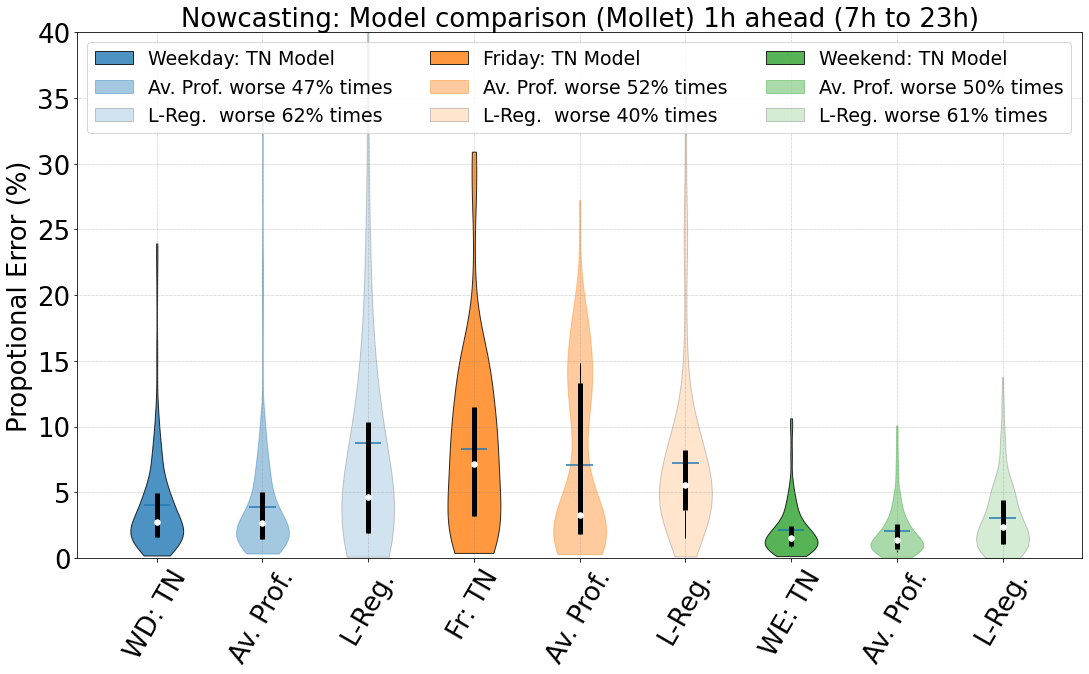

In [280]:
#fsize=18
fsizeFig14L=26
fsizeFig14S=19
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),reg_running_error_wd.flatten()*100,
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),reg_running_error_fr.flatten()*100,
        tn_running_error_we.flatten(),proto_running_error_we.flatten(),reg_running_error_we.flatten()*100]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

#ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
ax2.set_title("Nowcasting: Model comparison ("+ current_parking+') 1h ahead ('+str(starting_hour)
              + 'h to '+ str(ending_hour) +'h)', fontsize=fsizeFig14L)

parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%3==2:
        #pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.4)
        pc.set_edgecolor(color_vec[int((cc-1)/3)])
    elif cc%3==1:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.8)
        pc.set_edgecolor('black')
    else:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.2)
        pc.set_edgecolor('black')

  
    
quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
                                                     reg_running_error_wd.flatten()*100], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
                                                     reg_running_error_fr.flatten()*100], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten(),
                                                     reg_running_error_we.flatten()*100], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


np.set_printoptions(precision=2)
print(medians)



#propTHbetter_wd=sum(tn_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
#propTHbetter_fr=sum(tn_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())
propworseTN_wd=sum(proto_running_error_wd.flatten()>tn_running_error_wd.flatten())/len(tn_running_error_wd.flatten())
propworseTN_fr=sum(proto_running_error_fr.flatten()>tn_running_error_fr.flatten())/len(tn_running_error_fr.flatten())
propworseTN_we=sum(proto_running_error_we.flatten()>tn_running_error_we.flatten())/len(tn_running_error_we.flatten())
regworseTN_wd=sum(reg_running_error_wd.flatten()*100>tn_running_error_wd.flatten())/len(tn_running_error_wd.flatten())
regworseTN_fr=sum(reg_running_error_fr.flatten()*100>tn_running_error_fr.flatten())/len(tn_running_error_fr.flatten())
regworseTN_we=sum(reg_running_error_we.flatten()*100>tn_running_error_we.flatten())/len(tn_running_error_we.flatten())




# set style for the axes
#labels = ['WD: TN Model', 'WD: Av. Prof.','WD: Lin Reg.',
#          'Fr: TN Model', 'Fr: Av. Prof.','Fr: Lin Reg.',
#          'WE: TN Model', 'WE: Av. Prof.','WE: Lin Reg.']
labels = ['WD: TN', 'Av. Prof.','L-Reg.',
          'Fr: TN', 'Av. Prof.','L-Reg.',
          'WE: TN', 'Av. Prof.','L-Reg.']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)
plt.xticks(rotation =60)

#ax2.legend(['Weekday: TN Model','Weekday: Prototype','Weekday: Regression',
#            'Friday: TN Model','Friday: Prototype','Friday: Regression',
#           'Weekend: TN Model','Weekend: Prototype','Weekend: Regression'], fontsize=fsize,ncol=3)

ax2.legend(['Weekday: TN Model',
            'Av. Prof. worse ' +str(int(propworseTN_wd*100)) +'% times',
            'L-Reg.  worse ' +str(int(regworseTN_wd*100)) +'% times',
            'Friday: TN Model',
            'Av. Prof. worse ' +str(int(propworseTN_fr*100)) +'% times',
            'L-Reg.  worse ' +str(int(regworseTN_fr*100)) +'% times', 
            'Weekend: TN Model',
            'Av. Prof. worse ' +str(int(propworseTN_we*100)) +'% times',
            'L-Reg. worse ' +str(int(regworseTN_we*100)) +'% times'], 
           fontsize=fsizeFig14S, loc='upper left',ncol=3)


ax2.set_xlabel('')
ax2.tick_params(axis='y', labelsize=fsizeFig14L)
ax2.tick_params(axis='x', labelsize=fsizeFig14L)
ax2.set_ylabel('Propotional Error (%)',fontsize=fsizeFig14L)
if ax2.get_ylim()[1]>40 :
    plt.ylim([0,40])
if current_parking_ix==0:
    plt.ylim([0,12])
    
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionErrorREG_'+current_parking+'_violin_NOW1h.pdf',bbox_inches='tight');

In [281]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred_proto=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred_proto=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [282]:
f = open('data/'+current_parking+'_runnError_1h.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)
writer.writerow(m_row_runPred_proto)
writer.writerow(s_row_runPred_proto)

# close the file
f.close()